**Library Imports**:

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.cluster import DBSCAN

In [78]:
#set panda options to max display to view all columns:
pd.options.display.max_columns = None

## Problem Statement:

Can we use (socioeconomic, demographic, and employment data) to cluster states with higher risk of being affected by a pandemic to allot resources to those areas for future disproportionate effect mitigation?

## Data Cleaning & Merging:

**Data Imports:** Let's read in the socioeconomic determinants data along with the corresponding rolling aggregates for year end covid statistics:

In [94]:
df = pd.read_csv('data/Socioeconomic Data/Socioeconomic determinants/socioeconomic determinant for state.csv')
df_2 = pd.read_csv('data/csse_covid_19_daily_reports_us/12-31-2020.csv')
unemp_covid_df = pd.read_csv('data/yun_data/output/unemployment_covid_2020.csv')
covid_df = pd.read_csv('data/yun_data/output/covid_monthly_2020.csv')
df3 = pd.read_csv('data/yun_data/output/unemp_rate_2020.csv')
df4 = pd.read_csv('data/yun_data/output/cov_unemp_summary.csv')
df5 = pd.read_csv('data/yun_data/output/covid_socio_2020.csv')

In [80]:
#familiarize ourselves with each respective dataframes with .head(), also print out df shape to see how we'd like to merge
print(df.shape)
df.head()

(51, 26)


,FIPS,Name,Postal Code,Area size,Population size,Population density,Senior Population,Young Population,Male Population,White Population,Africa-American Population,Hispanic population,Internet access,High school degree,Bachelor degrees,Median household income,Poverty rate,Uninsured,Household size,House Owner,hospital,hospital bed,ICU bed,ventilator usage,Nurses,Medical Doctors
0,1,Alabama,AL,135767,4903185,36.114704,17.4,18.3,48.3,69.5,27.8,4.5,81.9,12.9,16.3,51734,15.5,9.7,2.60,68.8,119,18611,1637,383,85746,43429
1,2,Alaska,AK,1723337,731545,0.424493,12.4,21.0,52.0,71.4,4.7,7.2,88.0,6.4,18.5,75463,10.1,12.2,2.90,64.7,28,1832,193,41,15487,18418
2,4,Arizona,AZ,295234,7278717,24.654061,18.0,18.7,49.7,81.7,6.0,31.7,87.4,12.4,18.8,62055,13.5,11.3,2.71,65.3,125,18388,1882,427,93928,84130
3,5,Arkansas,AR,137732,3017804,21.910696,17.4,19.2,48.9,79.3,16.7,7.7,80.1,12.5,15.1,48952,16.2,9.1,2.59,65.5,105,12473,914,261,42487,47343
4,6,California,CA,423967,39512223,93.196459,14.8,18.7,49.7,63.6,7.0,39.4,90.0,16.0,21.9,80440,11.8,7.7,3.02,54.9,461,80893,8652,1986,444964,588052


In [81]:
#same as above for our second dataframe:
print(df_2.shape)
df_2.head()

(58, 18)


,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2021-01-01 05:30:27,32.3182,-86.9023,361226,4827,202137.0,154262.0,1.0,7367.170523,1874000.0,NaN,1.336283,84000001.0,USA,38220.054923,NaN
1,Alaska,US,2021-01-01 05:30:27,61.3707,-152.4044,46986,206,7165.0,39615.0,2.0,6422.844801,1275750.0,NaN,0.438428,84000002.0,USA,174391.185778,NaN
2,American Samoa,US,2021-01-01 05:30:27,-14.2710,-170.1320,0,0,NaN,0.0,60.0,0.000000,2140.0,NaN,NaN,16.0,ASM,3846.084722,NaN
3,Arizona,US,2021-01-01 05:30:27,33.7298,-111.4312,520207,8864,75981.0,435362.0,4.0,7146.960103,2834752.0,NaN,1.703937,84000004.0,USA,38945.764755,NaN
4,Arkansas,US,2021-01-01 05:30:27,34.9697,-92.3731,225138,3676,199247.0,22215.0,5.0,7460.325455,2051488.0,NaN,1.632776,84000005.0,USA,67979.497674,NaN


As we can see from the shapes, there are more rows in our second dataframe compared to our first dataframe. This is likely a result of the second dataset including additional US terrorities (which is shown via the inclusion of "American Samoa"). These differences could pose an issue when trying to simply concatenate our frames since the corresponding data won't line up. A easy solution is to utilize the inner join method, which will combine the two dataframes on a similar column but will only bond the frames that have entries for the corresponding columns we've elected to join on. So since our first df doesn't include these territories, our merged frame will not have them either and we should simply see a final merged df with 51 rows (50 states + Washington DC). To join via states we will have to indicate which columns that is for each respective df ('Name' & 'Province_State'):

In [82]:
dmf=df.merge(df_2, left_on='Name', right_on='Province_State')
print(dmf.shape)
dmf.head()

(51, 44)


,FIPS_x,Name,Postal Code,Area size,Population size,Population density,Senior Population,Young Population,Male Population,White Population,Africa-American Population,Hispanic population,Internet access,High school degree,Bachelor degrees,Median household income,Poverty rate,Uninsured,Household size,House Owner,hospital,hospital bed,ICU bed,ventilator usage,Nurses,Medical Doctors,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS_y,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,1,Alabama,AL,135767,4903185,36.114704,17.4,18.3,48.3,69.5,27.8,4.5,81.9,12.9,16.3,51734,15.5,9.7,2.60,68.8,119,18611,1637,383,85746,43429,Alabama,US,2021-01-01 05:30:27,32.3182,-86.9023,361226,4827,202137.0,154262.0,1.0,7367.170523,1874000.0,NaN,1.336283,84000001.0,USA,38220.054923,NaN
1,2,Alaska,AK,1723337,731545,0.424493,12.4,21.0,52.0,71.4,4.7,7.2,88.0,6.4,18.5,75463,10.1,12.2,2.90,64.7,28,1832,193,41,15487,18418,Alaska,US,2021-01-01 05:30:27,61.3707,-152.4044,46986,206,7165.0,39615.0,2.0,6422.844801,1275750.0,NaN,0.438428,84000002.0,USA,174391.185778,NaN
2,4,Arizona,AZ,295234,7278717,24.654061,18.0,18.7,49.7,81.7,6.0,31.7,87.4,12.4,18.8,62055,13.5,11.3,2.71,65.3,125,18388,1882,427,93928,84130,Arizona,US,2021-01-01 05:30:27,33.7298,-111.4312,520207,8864,75981.0,435362.0,4.0,7146.960103,2834752.0,NaN,1.703937,84000004.0,USA,38945.764755,NaN
3,5,Arkansas,AR,137732,3017804,21.910696,17.4,19.2,48.9,79.3,16.7,7.7,80.1,12.5,15.1,48952,16.2,9.1,2.59,65.5,105,12473,914,261,42487,47343,Arkansas,US,2021-01-01 05:30:27,34.9697,-92.3731,225138,3676,199247.0,22215.0,5.0,7460.325455,2051488.0,NaN,1.632776,84000005.0,USA,67979.497674,NaN
4,6,California,CA,423967,39512223,93.196459,14.8,18.7,49.7,63.6,7.0,39.4,90.0,16.0,21.9,80440,11.8,7.7,3.02,54.9,461,80893,8652,1986,444964,588052,California,US,2021-01-01 05:30:27,36.1162,-119.6816,2325599,25986,NaN,2265110.0,6.0,5798.223502,32855482.0,NaN,1.130376,84000006.0,USA,83152.704418,NaN


**51 rows with 44 columns. We have successfully merged our sets into one combined dataframe.**

Now let's check for any nulls:

In [83]:
dmf.isnull().sum()

FIPS_x                         0
Name                           0
Postal Code                    0
Area size                      0
Population size                0
Population density             0
Senior Population              0
Young Population               0
Male Population                0
White Population               0
Africa-American Population     0
Hispanic population            0
Internet access                0
High school degree             0
Bachelor degrees               0
Median household income        0
Poverty rate                   0
Uninsured                      0
Household size                 0
House Owner                    0
hospital                       0
hospital bed                   0
ICU bed                        0
ventilator usage               0
Nurses                         0
Medical Doctors                0
Province_State                 0
Country_Region                 0
Last_Update                    0
Lat                            0
Long_     

From above we can see that th entire People_Hospitalized and Hospitalization_Rate are null for the entire set. Since we cannot impute or calculate these metrics within reason, we can simply drop these columns. While we are at it, we can also drop any additional columns that we won't need for EDA and modeling purposes that will clutter up our dataframe.

In [84]:
# Drop unnecessary columns
dmf.drop(columns = ['FIPS_x','Province_State','Country_Region',
                    'Last_Update','Lat','Long_','FIPS_y','People_Hospitalized',
                    'UID','ISO3','Hospitalization_Rate'], inplace = True)

In [85]:
print(dmf.shape)
dmf.head()

(51, 33)


,Name,Postal Code,Area size,Population size,Population density,Senior Population,Young Population,Male Population,White Population,Africa-American Population,Hispanic population,Internet access,High school degree,Bachelor degrees,Median household income,Poverty rate,Uninsured,Household size,House Owner,hospital,hospital bed,ICU bed,ventilator usage,Nurses,Medical Doctors,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate
0,Alabama,AL,135767,4903185,36.114704,17.4,18.3,48.3,69.5,27.8,4.5,81.9,12.9,16.3,51734,15.5,9.7,2.60,68.8,119,18611,1637,383,85746,43429,361226,4827,202137.0,154262.0,7367.170523,1874000.0,1.336283,38220.054923
1,Alaska,AK,1723337,731545,0.424493,12.4,21.0,52.0,71.4,4.7,7.2,88.0,6.4,18.5,75463,10.1,12.2,2.90,64.7,28,1832,193,41,15487,18418,46986,206,7165.0,39615.0,6422.844801,1275750.0,0.438428,174391.185778
2,Arizona,AZ,295234,7278717,24.654061,18.0,18.7,49.7,81.7,6.0,31.7,87.4,12.4,18.8,62055,13.5,11.3,2.71,65.3,125,18388,1882,427,93928,84130,520207,8864,75981.0,435362.0,7146.960103,2834752.0,1.703937,38945.764755
3,Arkansas,AR,137732,3017804,21.910696,17.4,19.2,48.9,79.3,16.7,7.7,80.1,12.5,15.1,48952,16.2,9.1,2.59,65.5,105,12473,914,261,42487,47343,225138,3676,199247.0,22215.0,7460.325455,2051488.0,1.632776,67979.497674
4,California,CA,423967,39512223,93.196459,14.8,18.7,49.7,63.6,7.0,39.4,90.0,16.0,21.9,80440,11.8,7.7,3.02,54.9,461,80893,8652,1986,444964,588052,2325599,25986,NaN,2265110.0,5798.223502,32855482.0,1.130376,83152.704418


We also saw 7 nulls for the recovered column. This we ARE able to calculate with the given information. As we can deduce for the other entries, 'Recovered' metric is determined by 'Confirmed' cases subtracted by 'Deaths' then subtracted by 'Active'. Intuitively this makes sense so we can feel comfortable with this imputing method. 

Also it will be important to look at our covid metrics on a per capita basis otherwise our findings will certainly be less meaningful considering they will hold biases towards states with larger populations. So let's also add a few columns to our database by taking our interested metric and dividing it by corresponding state population size.

In [86]:
#imputing NaNs with intuation:
dmf['Recovered'] = dmf['Confirmed'] - dmf['Deaths'] - dmf['Active']

#creating per capita columns:
dmf['deaths_per_population'] = dmf['Deaths'] / dmf['Population size']
dmf['recovered_per_population'] = dmf['Recovered'] / dmf['Population size']
dmf['confirmed_per_population'] = dmf['Confirmed'] / dmf['Population size']
dmf['active_per_population'] = dmf['Active'] / dmf['Population size']
print(dmf.shape)
dmf.head()

(51, 37)


,Name,Postal Code,Area size,Population size,Population density,Senior Population,Young Population,Male Population,White Population,Africa-American Population,Hispanic population,Internet access,High school degree,Bachelor degrees,Median household income,Poverty rate,Uninsured,Household size,House Owner,hospital,hospital bed,ICU bed,ventilator usage,Nurses,Medical Doctors,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,deaths_per_population,recovered_per_population,confirmed_per_population,active_per_population
0,Alabama,AL,135767,4903185,36.114704,17.4,18.3,48.3,69.5,27.8,4.5,81.9,12.9,16.3,51734,15.5,9.7,2.60,68.8,119,18611,1637,383,85746,43429,361226,4827,202137.0,154262.0,7367.170523,1874000.0,1.336283,38220.054923,0.000984,0.041226,0.073672,0.031462
1,Alaska,AK,1723337,731545,0.424493,12.4,21.0,52.0,71.4,4.7,7.2,88.0,6.4,18.5,75463,10.1,12.2,2.90,64.7,28,1832,193,41,15487,18418,46986,206,7165.0,39615.0,6422.844801,1275750.0,0.438428,174391.185778,0.000282,0.009794,0.064228,0.054153
2,Arizona,AZ,295234,7278717,24.654061,18.0,18.7,49.7,81.7,6.0,31.7,87.4,12.4,18.8,62055,13.5,11.3,2.71,65.3,125,18388,1882,427,93928,84130,520207,8864,75981.0,435362.0,7146.960103,2834752.0,1.703937,38945.764755,0.001218,0.010439,0.071470,0.059813
3,Arkansas,AR,137732,3017804,21.910696,17.4,19.2,48.9,79.3,16.7,7.7,80.1,12.5,15.1,48952,16.2,9.1,2.59,65.5,105,12473,914,261,42487,47343,225138,3676,199247.0,22215.0,7460.325455,2051488.0,1.632776,67979.497674,0.001218,0.066024,0.074603,0.007361
4,California,CA,423967,39512223,93.196459,14.8,18.7,49.7,63.6,7.0,39.4,90.0,16.0,21.9,80440,11.8,7.7,3.02,54.9,461,80893,8652,1986,444964,588052,2325599,25986,34503.0,2265110.0,5798.223502,32855482.0,1.130376,83152.704418,0.000658,0.000873,0.058858,0.057327


Before we proceed to EDA steps, let's double check to make sure we have properly cleaned up any nulls/missing data:

In [87]:
dmf.isnull().sum()

Name                          0
Postal Code                   0
Area size                     0
Population size               0
Population density            0
Senior Population             0
Young Population              0
Male Population               0
White Population              0
Africa-American Population    0
Hispanic population           0
Internet access               0
High school degree            0
Bachelor degrees              0
Median household income       0
Poverty rate                  0
Uninsured                     0
Household size                0
House Owner                   0
hospital                      0
hospital bed                  0
ICU bed                       0
ventilator usage              0
Nurses                        0
Medical Doctors               0
Confirmed                     0
Deaths                        0
Recovered                     0
Active                        0
Incident_Rate                 0
Total_Test_Results            0
Case_Fat

## EDA

### Unemployment:

Since one of the impacted areas we are interested in is unemployment, we first wanted to chart the number of cases/deaths over the year along with the national rate of unemployment over the year.

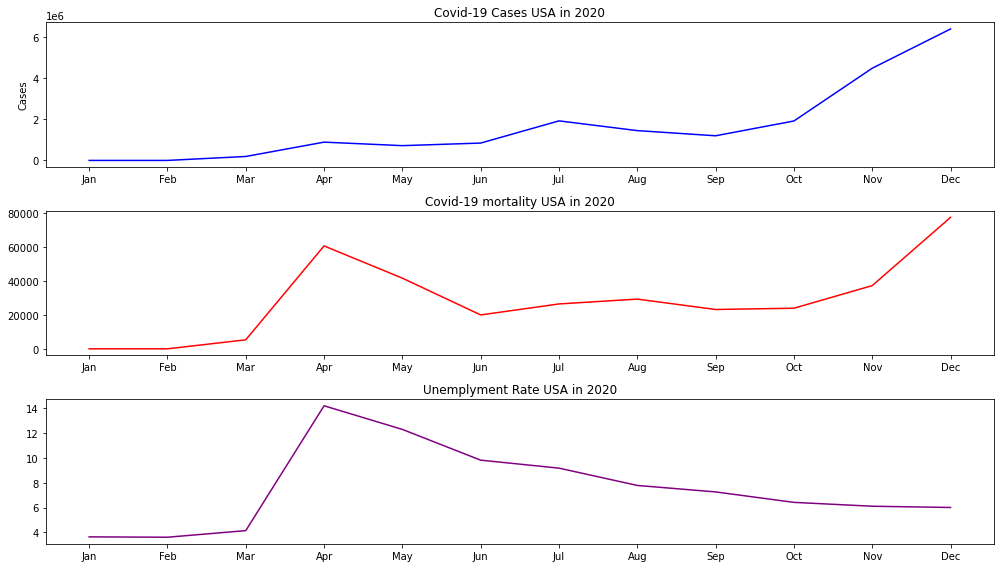

In [89]:
plt.figure(figsize = (14,8))

ax1 = plt.subplot(3, 1, 1)
ax1.plot(df4['month'],df4['cases'], color = 'blue')
ax1.set_title('Covid-19 Cases USA in 2020')
ax1.set_ylabel('Cases')

ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(df4['death'], color = 'red')
ax2.set_title("Covid-19 Deaths USA in 2020")

ax3 = plt.subplot(3, 1, 3, sharex=ax2)
ax3.plot(df4['unemp_rate'], color = 'purple' )
ax3.set_title('Unemplyment Rate USA in 2020')
plt.tight_layout();

As we can see there is a big spike in both death and unemployment in the early ongoing of the pandemic breakout, which would make since considering how new the virus was. Hospitals and doctors had very limited knowledge on how to treat patients properly, as well companies were forced into unfamiliar terriroty with having to shut down causing a huge spike in employees losing their jobs.

### Demographics:

Another area of exploration for our project was to see if there is any correlations between covid and different demographics. The demographics we are going to examine from our dataframe will be the race and age along with the population and it's density. We've created a heatmap to investigate deaths and confirmed cases (on a per capita basis) to try and reveal any demographics that might raise any concerns based on their respective correlations:  

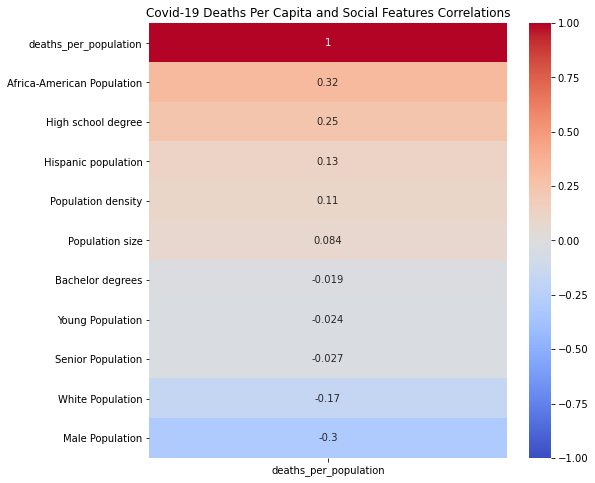

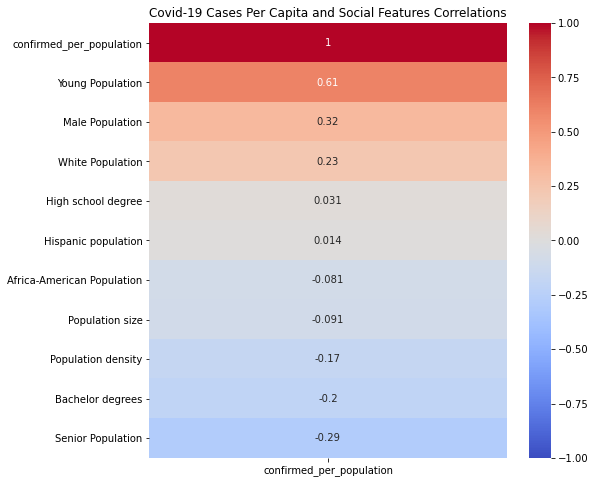

In [102]:
plt.figure(figsize=(8, 8))
sns.heatmap(dmf[['deaths_per_population', 'Population size',
       'Population density', 'Senior Population', 'Young Population',
       'Male Population', 'White Population', 'Africa-American Population',
       'Hispanic population','High school degree',
       'Bachelor degrees']].corr()[['deaths_per_population']].sort_values('deaths_per_population', ascending=False),
            annot=True,
            cmap='coolwarm',
            vmin=-1, 
            vmax=1)
plt.title('Covid-19 Deaths Per Capita and Social Features Correlations')

plt.figure(figsize=(8, 8))
sns.heatmap(dmf[['confirmed_per_population', 'Population size',
       'Population density', 'Senior Population', 'Young Population',
       'Male Population', 'White Population', 'Africa-American Population',
       'Hispanic population','High school degree',
       'Bachelor degrees']].corr()[['confirmed_per_population']].sort_values('confirmed_per_population', ascending=False),
            annot=True,
            cmap='coolwarm',
            vmin=-1, 
            vmax=1)
plt.title('Covid-19 Cases Per Capita and Social Features Correlations');

**Findings:** From the above heatmaps we can already speculate that the impact of covid might be disproportionate across different demographics. The most alarming area being the correlation with the African-American Population. As we can see from the deaths per capita heatmap the African-American population measures the highest correlational value of 0.32, but in respect to confirmed cases, a much lower, almost neutral -0.081. Additionally, we see that the white population correlates negatively with deaths per capita at -0.17, but then positively at 0.23. This leads us to believe that there might be some sort of discrepencies in how different demographics are treated as patients and the care they are provided. 

Let's do the same for Economic factors and see if there's anything we can uncover:

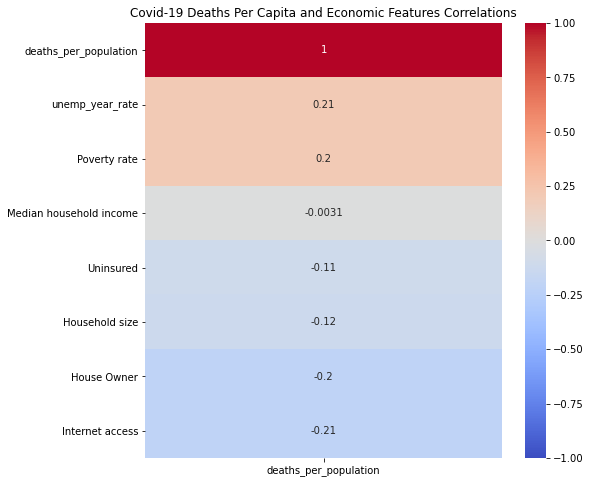

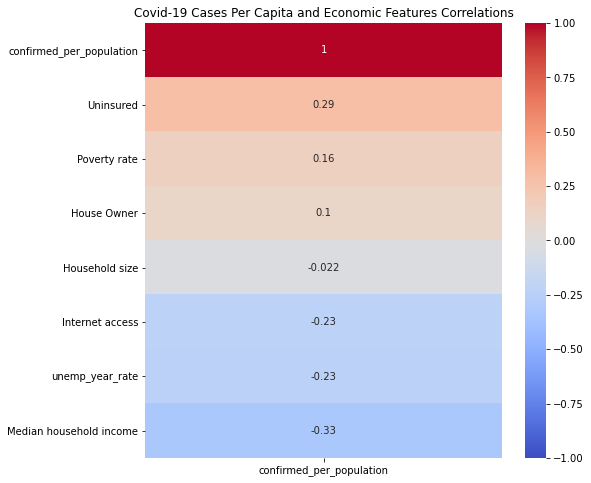

In [101]:

plt.figure(figsize=(8, 8))
sns.heatmap(df5[['deaths_per_population','Internet access', 'Median household income', 'Poverty rate',
       'Uninsured', 'Household size', 'House Owner','unemp_year_rate']].corr()[['deaths_per_population']].sort_values('deaths_per_population', ascending = False),
            annot=True,
            cmap='coolwarm',
            vmin=-1, 
            vmax=1)
plt.title('Covid-19 Deaths Per Capita and Economic Features Correlations')

plt.figure(figsize=(8, 8))
sns.heatmap(df5[['confirmed_per_population','Internet access', 'Median household income', 'Poverty rate',
       'Uninsured', 'Household size', 'House Owner','unemp_year_rate']].corr()[['confirmed_per_population']].sort_values('confirmed_per_population', ascending = False),
            annot=True,
            cmap='coolwarm',
            vmin=-1, 
            vmax=1)
plt.title('Covid-19 Cases Per Capita and Economic Features Correlations');

**Findings:** What jumps out as potential concerns are the poverty rate and average unemployment rate relationships with deaths per capita and cases per capita. As we can see poverty rate correlates at a rate of 0.2 and 0.16 with deaths and cases respectively, so that indicates we would want to help identify states with higher poverty rates as they would be areas of concern both in attempting to mitigate cases, but also areas that could possibly required improved patient treatment (with hopes of keeping them alive). 

From an unemployment rate we see it correlates negatively with confirmed cases (-0.23), but positively with deaths (0.21). Let's analyze this and try to reason with what this is telling us. Well, with higher rates of unemployment that would mean that people will be without jobs so more likely to be at home and mitigate the spread. While this is a positive result, the concerning other side of the coin is that these same rates inversely correlate positively with deaths per population. A reasonable inference from this could be that while unemployment leads to less cases, the unemployed folks who DO end up contracting the virus will have a tougher time paying for/getting treatment which allow them to survive leading to a higher correlation with deaths.    

**CFR: Case Fatality Ratio**

Another metric of concern is the Case Fatality Ratio. The WHO (https://www.who.int/news-room/commentaries/detail/estimating-mortality-from-covid-19) describes as CFR as:
(Number of Deaths from Disease / Number of Confirmed Cases of Disease) * 100. So essentially this metric is telling us, among all of the cases in each state, at what rate are people dying from the virus. So in layman's terms, a higher CFR rate means that people are at a higher risk of dying from contracting the virus as opposed to a lower rate. With this knowledge we will want to pay special attention to areas with higher rates. 

Let's take a look at our correlational heatmap for CFR against the same social features we looked at before. Another good visualization is to utilize pairplots to see if there is any sort of observable trends:

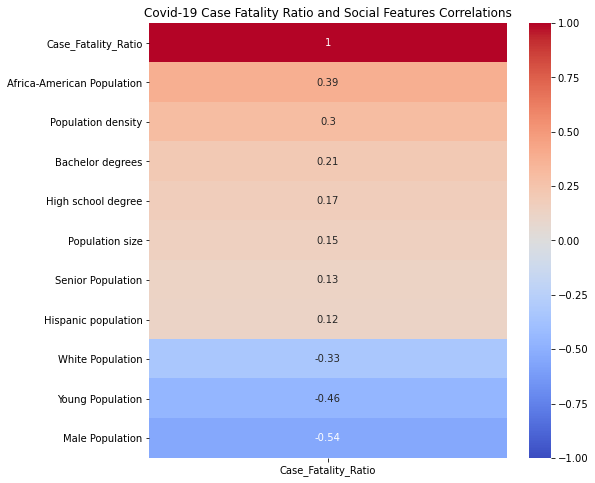

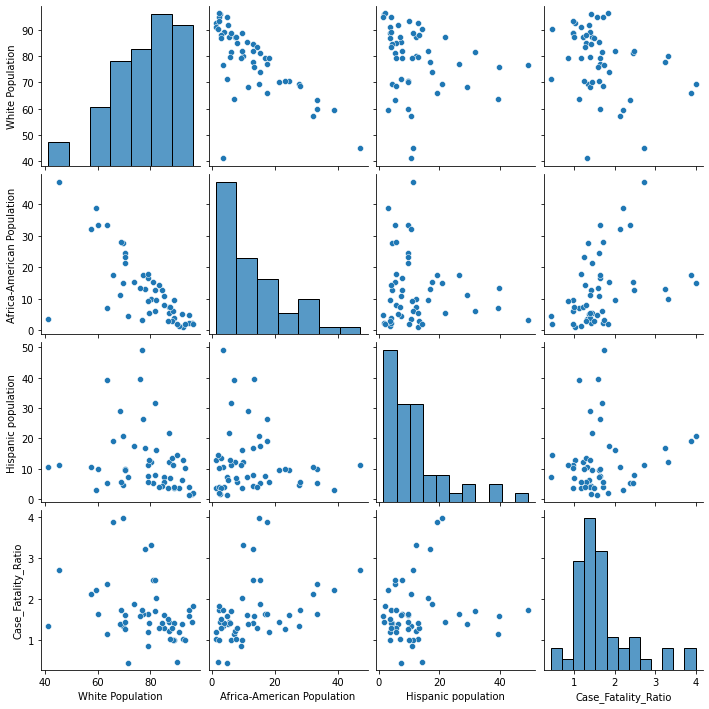

In [100]:
plt.figure(figsize=(8, 8))
sns.heatmap(dmf[['Case_Fatality_Ratio', 'Population size',
       'Population density', 'Senior Population', 'Young Population',
       'Male Population', 'White Population', 'Africa-American Population',
       'Hispanic population','High school degree',
       'Bachelor degrees']].corr()[['Case_Fatality_Ratio']].sort_values('Case_Fatality_Ratio', ascending=False),
            annot=True,
            cmap='coolwarm',
            vmin=-1, 
            vmax=1)
plt.title('Covid-19 Case Fatality Ratio and Social Features Correlations')

sns.pairplot(dmf[[ 'White Population', 'Africa-American Population',
       'Hispanic population', 'Case_Fatality_Ratio']]);

**Findings:** Again we see African-American population as the highest correlation amongst features, Hispanic as positive but more moderate, but White population again as negatively correlated. Despite white population making up the vast majority of population, the ratios indicate that the African American Population is most disproportionately affected by the virus from a CFR standpoint. Examining this metric supports our initial deaths per capita cut, so evidence is beginning to mount that there should be some sort of special attention giving to areas with higher African American populations from a treatment/healthcare standpoint as they seem to correlate at concerning levels continuously across our data/EDA methods. 

As we have established, states with higher rates of CFR will be the states that will need the highest level of support. To help us identify these states, let's create an additional column and provide a label of '1' for the states that fall in the top 25% for CFR and a '0' for the remaining bottom 75%. This will help us better visualize trends from a clustering standpoint through our pairplotting. Let's start by performing a .describe on this column to find our benchmarks:

In [112]:
# .describe() reveals that any state higher than 1.784340 CFR will fall in the 25% of our data and will be ones to track:
df5['Case_Fatality_Ratio'].describe()

count    51.000000
mean      1.660667
std       0.738485
min       0.438428
25%       1.265137
50%       1.440899
75%       1.784340
max       3.989023
Name: Case_Fatality_Ratio, dtype: float64

In [113]:
#creating a new column, appling our boolean values as int (booleans built on 0s & 1s)
df5['top_25_cfr']=(df5['Case_Fatality_Ratio'] > 1.784340).astype(int)

Now let's create a dataframes with just the features that we've determined might be of most value to us (racial demographics, poverty, unemployment, and # of hospitals) along with our CFR rate and deaths per capita. We will also cluster based on states falling in the top 25% of CFR to highlight any possible concerning trends. To make it easier on the eyes, we will seperate out three groupings for each racial demographic:

In [118]:
selected=pd.DataFrame(df5[['Poverty rate', 'hospital', 'White Population', 'Africa-American Population',
       'Hispanic population', 'Case_Fatality_Ratio', 'top_25_cfr', 'unemp_year_rate', 'deaths_per_population']])

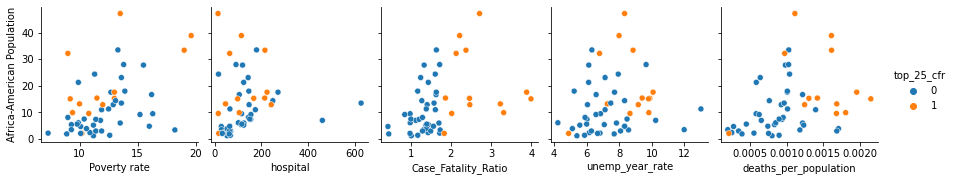

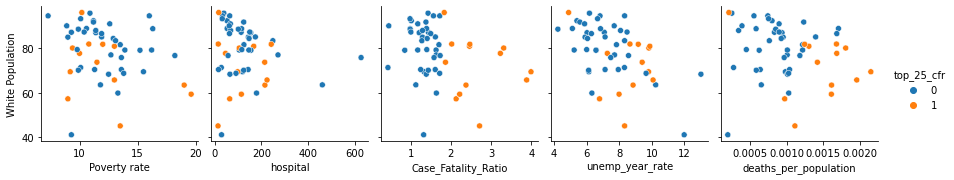

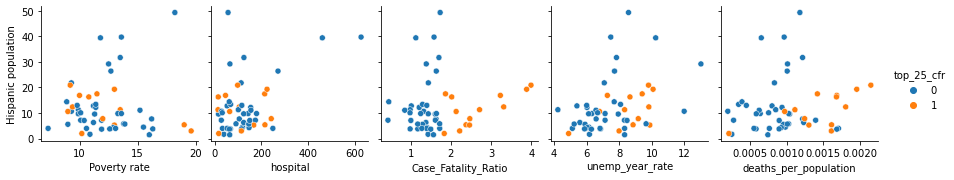

In [124]:
#with diag_kind help from: https://stackoverflow.com/questions/64369966/why-seaborns-pairplot-does-not-plot-the-first-plot
sns.pairplot(selected, x_vars = ['Poverty rate', 'hospital', 'Case_Fatality_Ratio','unemp_year_rate', 'deaths_per_population'],
             y_vars = ['Africa-American Population'], diag_kind = None, hue='top_25_cfr')

sns.pairplot(selected, x_vars = ['Poverty rate', 'hospital', 'Case_Fatality_Ratio','unemp_year_rate', 'deaths_per_population'],
             y_vars = ['White Population'], diag_kind = None, hue='top_25_cfr')

sns.pairplot(selected, x_vars = ['Poverty rate', 'hospital', 'Case_Fatality_Ratio','unemp_year_rate', 'deaths_per_population'],
             y_vars = ['Hispanic population'], diag_kind = None, hue='top_25_cfr');

From the above series of pairplots, the things that once again that are most concerning to us are the trending for CFR across different racial demographics as well the unemployment yearly rates. While there certainly are underlying factors driving unemployment, it still shows that with the African American population as the percentage increases so does the unemployment rate, whereas with white population it trends inversely. As we have seen earlier in our EDA, the effect of unemployement rate is correlated with deaths per capita, so transitively we can highlight that again the African-American population will need the most support to effectively combat the virus from a treatment standpoint. 